In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import random
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, \
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [4]:
# diseases = os.listdir('data')

# filenames = []

# for disease in dataset:
#     for file in os.listdir(os.path.join('data',disease)):
#         filenames.append(os.path.join('data',disease,file))
    
# #print (filenames[3000:])
# pickle.dump(filenames,open('filenames.pkl','wb'))

In [5]:
our_folders = ['Acne', \
              'Eczema', \
              'Melanoma',\
              'Melasma',\
              'Psoriasis',
              'Rosacea',\
              'Shingles'\
              'Urticaria']

In [6]:
root_dir = 'drive/MyDrive/data'

In [7]:
acne_path = os.path.join(root_dir,'Acne')
eczema_path = os.path.join(root_dir, 'Eczema')
melanoma_path = os.path.join(root_dir, 'Melanoma')
melasma_path = os.path.join(root_dir,'Melasma')
psoriasis_path = os.path.join(root_dir, 'Psoriasis')
rosacea_path = os.path.join(root_dir, 'Rosacea')
shingles_path = os.path.join(root_dir,'Shingles')
urticaria_path = os.path.join(root_dir, 'Urticaria')


In [8]:
acne_images=([files for _, _, files in os.walk(acne_path)])[0]
eczema_images=([files for _, _, files in os.walk(eczema_path)])[0]
melanoma_images=([files for _, _, files in os.walk(melanoma_path)])[0]
melasma_images=([files for _, _, files in os.walk(melasma_path)])[0]
psoriasis_images=([files for _, _, files in os.walk(psoriasis_path)])[0]
rosacea_images=([files for _, _, files in os.walk(rosacea_path)])[0]
shingles_images=([files for _, _, files in os.walk(shingles_path)])[0]
urticaria_images=([files for _, _, files in os.walk(urticaria_path)])[0]

In [9]:
len(rosacea_images)

383

### Putting all images and their assinged labels into a Dataframe

In [19]:
diseases = os.listdir('drive/MyDrive/data')

image_list =[]
label_list=[]

for disease in diseases:
    for img in os.listdir(os.path.join('drive/MyDrive/data',disease)):
        image_list.append(os.path.join('drive/MyDrive/data',disease,img))
        label_list.append(disease)
        
    
#print (filenames[3000:])
#pickle.dump(filenames,open('filenames.pkl','wb'))

In [20]:
len(image_list), len(label_list)

(3390, 3390)

In [21]:
df=pd.DataFrame()

In [22]:
df['Image']=pd.DataFrame(image_list)
df['Label']=pd.DataFrame(label_list)

In [23]:
df.shape

(3390, 2)

In [24]:
df

,Image,Label
0,drive/MyDrive/data/Rosacea/Rosacea (13).jpg,Rosacea
1,drive/MyDrive/data/Rosacea/Rosacea (8).jpg,Rosacea
2,drive/MyDrive/data/Rosacea/Rosacea (7).jpg,Rosacea
3,drive/MyDrive/data/Rosacea/Rosacea (5).jpg,Rosacea
4,drive/MyDrive/data/Rosacea/Rosacea (12).jpg,Rosacea
...,...,...
3385,drive/MyDrive/data/Psoriasis/Psoriasis (166).jpeg,Psoriasis
3386,drive/MyDrive/data/Psoriasis/Psoriasis (167).jpeg,Psoriasis
3387,drive/MyDrive/data/Psoriasis/Psoriasis (168).jpeg,Psoriasis
3388,drive/MyDrive/data/Psoriasis/Psoriasis (169).jpeg,Psoriasis


In [27]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df, stratify=df['Label'],test_size=0.25, random_state=42)  


In [28]:
train_df['Label'].value_counts()

Melanoma     483
Acne         418
Urticaria    335
Eczema       333
Rosacea      287
Psoriasis    257
Shingles     245
Melasma      184
Name: Label, dtype: int64

In [29]:
test_df['Label'].value_counts()

Melanoma     161
Acne         139
Urticaria    112
Eczema       111
Rosacea       96
Psoriasis     86
Shingles      82
Melasma       61
Name: Label, dtype: int64

In [30]:
train_data_gen  = ImageDataGenerator(
                                    rescale=1 / 255.0,
                                    rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    zoom_range=0.3,
                                    validation_split=0.2,
                                    fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1 / 255.0)

In [31]:
batch_size = 32
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image",
    y_col="Label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image",
    y_col="Label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical", 
    subset='validation',
    shuffle=True,
    seed=42 
)
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image",
    y_col="Label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    
)

Found 2034 validated image filenames belonging to 8 classes.
Found 508 validated image filenames belonging to 8 classes.
Found 848 validated image filenames belonging to 8 classes.


In [32]:
pip install efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import efficientnet.keras as efn

base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [34]:
for layer in base_model.layers:
    #print(layer.name)
      layer.trainable = True
    
print(len(base_model.layers))

230


In [35]:
base_model.output_shape

(None, 7, 7, 1280)

In [36]:
# Flatten the output layer to 1 dimension

x = layers.GlobalAveragePooling2D()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
#x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.
#x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x =  BatchNormalization()(x)

# Add a final sigmoid layer for classification
x = layers.Dense(8, activation='softmax')(x)

# Configure and compile the model

model = Model(base_model.input, x)
#optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['categorical_accuracy'])


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                             

In [37]:
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=0.01, 
    mode='min',
    verbose=1
)
filepath="drive/MyDrive/best_weights_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=1)

In [38]:
history = model.fit(train_generator,
                    epochs=50, 
                    validation_data=valid_generator,
                   callbacks=[learning_rate_reduction, checkpoint, custom_early_stopping  ],
                  )

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 1.4121 - categorical_accuracy: 0.5560
Epoch 1: val_categorical_accuracy improved from -inf to 0.32677, saving model to drive/MyDrive/best_weights_1.hdf5
64/64 [==============================] - 74s 886ms/step - loss: 1.4121 - categorical_accuracy: 0.5560 - val_loss: 1.8903 - val_categorical_accuracy: 0.3268 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.7387 - categorical_accuracy: 0.7488
Epoch 2: val_categorical_accuracy improved from 0.32677 to 0.37008, saving model to drive/MyDrive/best_weights_1.hdf5
64/64 [==============================] - 49s 758ms/step - loss: 0.7387 - categorical_accuracy: 0.7488 - val_loss: 1.9283 - val_categorical_accuracy: 0.3701 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - ETA: 0s - loss: 0.6237 - categorical_accuracy: 0.7812
Epoch 3: val_categorical_accuracy improved from 0.37008 to 0.47441, saving model to drive/MyDrive/best_weights_

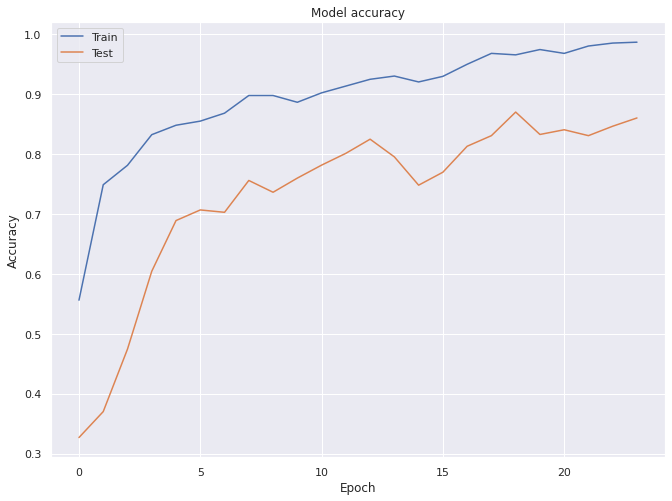

In [46]:
#plot accuracy vs epoch
plt.plot(history.history['categorical_accuracy']) 
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

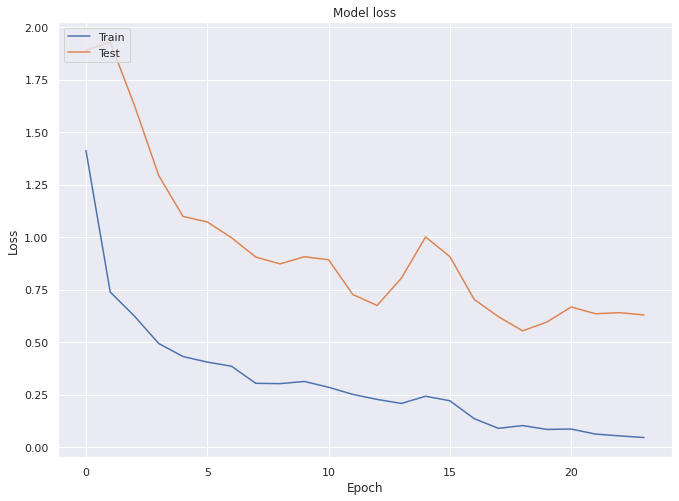

In [47]:
# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [48]:
test_true=test_generator.classes
test_pred_raw = model.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)



848/848 [==============================] - 11s 13ms/step


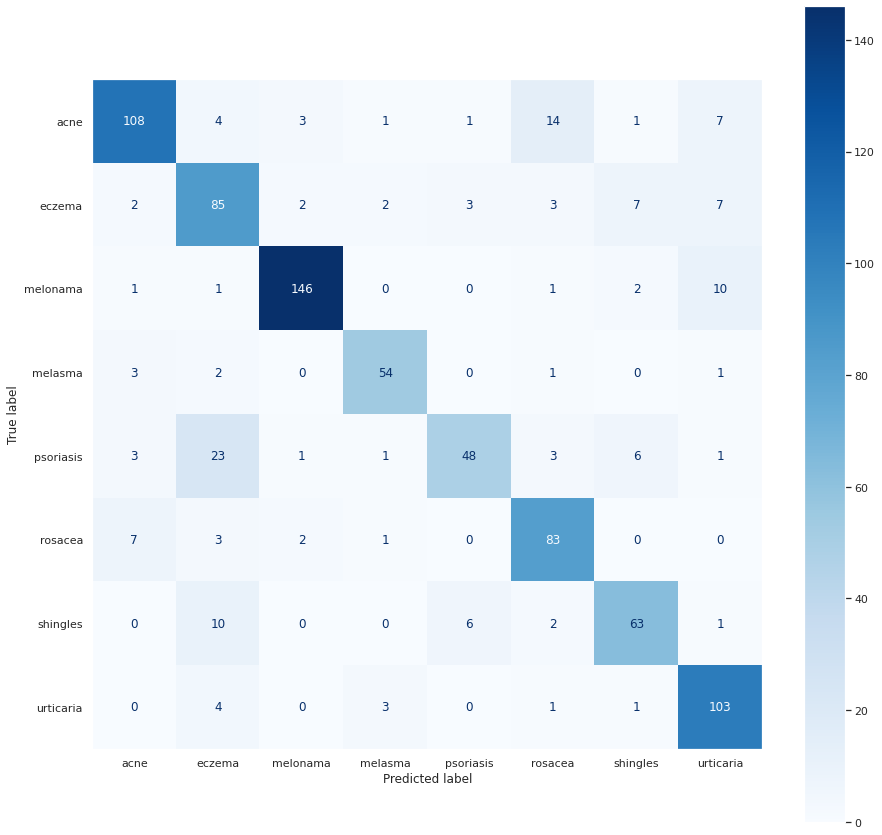

In [49]:
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['acne','eczema','melonama','melasma','psoriasis','rosacea', 'shingles','urticaria'])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [50]:
result = model.evaluate(test_generator,batch_size=32)
print("test_loss, test accuracy",result)

848/848 [==============================] - 13s 15ms/step - loss: 0.7443 - categorical_accuracy: 0.8137
test_loss, test accuracy [0.7443191409111023, 0.8136792182922363]


In [51]:
acc = accuracy_score(test_true, test_pred)
print("Inception Model Accuracy: {:.2f}%".format(acc * 100))

Inception Model Accuracy: 81.37%


In [45]:
from keras.models import load_model
model.save("drive/MyDrive/Retraining_EfficientNet.h5")